# Linear Regression

## 2. Data Understanding

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 08:05:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/11 08:05:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
!pip install scikit-learn
!pip install numpy
!pip install sweetviz
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
from sklearn import linear_model
regr = linear_model.LinearRegression()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


<h3 id="understanding_data">Understanding the Data</h3>

In [3]:
import os
print(os.getcwd())
df = pd.read_csv("/home/ubuntu/WHO-COVID-19-global-table-data.csv")
# take a look at the dataset
df.head(3)

/home/ubuntu/Machine-Learning-with-Python-and-Spark/Linear-Regression


,Name,WHO Region,Cases - cumulative total,Cases - cumulative total per 100000 population,Cases - newly reported in last 7 days,Cases - newly reported in last 7 days per 100000 population,Cases - newly reported in last 24 hours,Deaths - cumulative total,Deaths - cumulative total per 100000 population,Deaths - newly reported in last 7 days,Deaths - newly reported in last 7 days per 100000 population,Deaths - newly reported in last 24 hours
Global,NaN,769369823,9870.624662,34812,0.44662,0,6954336,89.220604,147,0.001886,0,NaN
United States of America,Americas,103436829,31249.547000,0,0.00000,0,1127152,340.527000,0,0.000000,0,NaN
China,Western Pacific,99300923,6749.256000,553,0.03800,0,121628,8.267000,0,0.000000,0,NaN


Lets select some features that we want to use for regression.

In [4]:
df_spark = spark.read.csv("/home/ubuntu/WHO-COVID-19-global-table-data.csv")
df_spark.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)



In [5]:
cdf = df[["Cases - cumulative total", "Deaths - cumulative total"]]
cdf.head(3)

,Cases - cumulative total,Deaths - cumulative total
Global,9870.624662,89.220604
United States of America,31249.547000,340.527000
China,6749.256000,8.267000


Lets plot Yearly Amount Spent values with respect to Length of Membership:

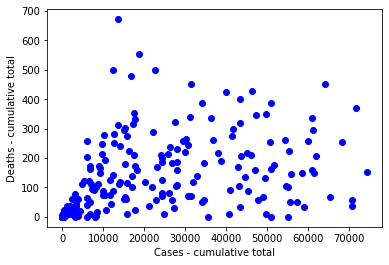

In [6]:
plt.scatter(cdf[["Cases - cumulative total"]], cdf[["Deaths - cumulative total"]],  color='blue')
plt.xlabel("Cases - cumulative total")
plt.ylabel("Deaths - cumulative total")
plt.show()

## 3. Data Prepatation

### 3.1 Data Quality

In [7]:
# Use Spark to read in the Ecommerce Customers csv file.
df_spark = spark.read.csv("/home/ubuntu/WHO-COVID-19-global-table-data.csv",inferSchema=True,header=True)
df_spark.describe().show()

+-------+--------------------+---------------+------------------------+----------------------------------------------+-------------------------------------+-----------------------------------------------------------+---------------------------------------+-------------------------+-----------------------------------------------+--------------------------------------+------------------------------------------------------------+----------------------------------------+
|summary|                Name|     WHO Region|Cases - cumulative total|Cases - cumulative total per 100000 population|Cases - newly reported in last 7 days|Cases - newly reported in last 7 days per 100000 population|Cases - newly reported in last 24 hours|Deaths - cumulative total|Deaths - cumulative total per 100000 population|Deaths - newly reported in last 7 days|Deaths - newly reported in last 7 days per 100000 population|Deaths - newly reported in last 24 hours|
+-------+--------------------+---------------+----------

In [8]:
from pyspark.sql.functions import col, sum

df_spark.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+----+----------+------------------------+----------------------------------------------+-------------------------------------+-----------------------------------------------------------+---------------------------------------+-------------------------+-----------------------------------------------+--------------------------------------+------------------------------------------------------------+----------------------------------------+
|Name|WHO Region|Cases - cumulative total|Cases - cumulative total per 100000 population|Cases - newly reported in last 7 days|Cases - newly reported in last 7 days per 100000 population|Cases - newly reported in last 24 hours|Deaths - cumulative total|Deaths - cumulative total per 100000 population|Deaths - newly reported in last 7 days|Deaths - newly reported in last 7 days per 100000 population|Deaths - newly reported in last 24 hours|
+----+----------+------------------------+----------------------------------------------+-------------------------

### 3.2 Cleaning the data

In [9]:
df_spark.drop("Deaths - newly reported in last 24 hours")

DataFrame[Name: string, WHO Region: string, Cases - cumulative total: int, Cases - cumulative total per 100000 population: double, Cases - newly reported in last 7 days: int, Cases - newly reported in last 7 days per 100000 population: double, Cases - newly reported in last 24 hours: int, Deaths - cumulative total: int, Deaths - cumulative total per 100000 population: double, Deaths - newly reported in last 7 days: int, Deaths - newly reported in last 7 days per 100000 population: double]

In [10]:
df_spark.head(3)

[Row(Name='Global', WHO Region=None, Cases - cumulative total=769369823, Cases - cumulative total per 100000 population=9870.624662449067, Cases - newly reported in last 7 days=34812, Cases - newly reported in last 7 days per 100000 population=0.4466203059658828, Cases - newly reported in last 24 hours=0, Deaths - cumulative total=6954336, Deaths - cumulative total per 100000 population=89.22060416263218, Deaths - newly reported in last 7 days=147, Deaths - newly reported in last 7 days per 100000 population=0.0018859354526308378, Deaths - newly reported in last 24 hours=0),
 Row(Name='United States of America', WHO Region='Americas', Cases - cumulative total=103436829, Cases - cumulative total per 100000 population=31249.547, Cases - newly reported in last 7 days=0, Cases - newly reported in last 7 days per 100000 population=0.0, Cases - newly reported in last 24 hours=0, Deaths - cumulative total=1127152, Deaths - cumulative total per 100000 population=340.527, Deaths - newly reporte

### 3.3 Construct the Data 

In [11]:
from pyspark.sql.functions import when

df_spark = df_spark.withColumn(
    "Death Rate",
    when(df_spark["Cases - cumulative total"] != 0, df_spark["Deaths - cumulative total"] / df_spark["Cases - cumulative total"]).otherwise(0)
)
df_spark.printSchema()

root
 |-- Name: string (nullable = true)
 |-- WHO Region: string (nullable = true)
 |-- Cases - cumulative total: integer (nullable = true)
 |-- Cases - cumulative total per 100000 population: double (nullable = true)
 |-- Cases - newly reported in last 7 days: integer (nullable = true)
 |-- Cases - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Cases - newly reported in last 24 hours: integer (nullable = true)
 |-- Deaths - cumulative total: integer (nullable = true)
 |-- Deaths - cumulative total per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 7 days: integer (nullable = true)
 |-- Deaths - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 24 hours: integer (nullable = true)
 |-- Death Rate: double (nullable = true)



In [12]:
from pyspark.sql.functions import when

df_spark = df_spark.withColumn(
    "Recovery Rate",
    when(df_spark["Cases - cumulative total"] != 0, 1 - df_spark["Deaths - cumulative total"] / df_spark["Cases - cumulative total"]).otherwise(0)
)
df_spark.printSchema()

root
 |-- Name: string (nullable = true)
 |-- WHO Region: string (nullable = true)
 |-- Cases - cumulative total: integer (nullable = true)
 |-- Cases - cumulative total per 100000 population: double (nullable = true)
 |-- Cases - newly reported in last 7 days: integer (nullable = true)
 |-- Cases - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Cases - newly reported in last 24 hours: integer (nullable = true)
 |-- Deaths - cumulative total: integer (nullable = true)
 |-- Deaths - cumulative total per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 7 days: integer (nullable = true)
 |-- Deaths - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 24 hours: integer (nullable = true)
 |-- Death Rate: double (nullable = true)
 |-- Recovery Rate: double (nullable = true)



### 3.5 Reformatting the data

In [13]:
Western_Pacific_data = df_spark.where(df_spark['WHO Region'] == 'Western Pacific')
Western_Pacific_data.head(10)

[Row(Name='China', WHO Region='Western Pacific', Cases - cumulative total=99300923, Cases - cumulative total per 100000 population=6749.256, Cases - newly reported in last 7 days=553, Cases - newly reported in last 7 days per 100000 population=0.038, Cases - newly reported in last 24 hours=0, Deaths - cumulative total=121628, Deaths - cumulative total per 100000 population=8.267, Deaths - newly reported in last 7 days=0, Deaths - newly reported in last 7 days per 100000 population=0.0, Deaths - newly reported in last 24 hours=0, Death Rate=0.0012248425928528379, Recovery Rate=0.9987751574071472),
 Row(Name='Japan', WHO Region='Western Pacific', Cases - cumulative total=33803572, Cases - cumulative total per 100000 population=26727.165, Cases - newly reported in last 7 days=0, Cases - newly reported in last 7 days per 100000 population=0.0, Cases - newly reported in last 24 hours=0, Deaths - cumulative total=74694, Deaths - cumulative total per 100000 population=59.058, Deaths - newly r

## 4. Data Transformation

### 4.1 Data Reducing

In [14]:
from pyspark.sql.functions import col

# 1. Select columns for all numeric types
numeric_columns = [name for name, dtype in Western_Pacific_data.dtypes if dtype in ["int", "double"]]

data_Importance = Western_Pacific_data.select(numeric_columns)

# 2. Select columns for all numeric types
correlation_matrix = {}
for column in numeric_columns:
    correlation_value = data_Importance.stat.corr(column, "Recovery Rate")
    correlation_matrix[column] = correlation_value

# 3. Print the correlations of the other columns associated with the Recovery Rate column, in descending order
sorted_correlation = sorted(correlation_matrix.items(), key=lambda x: x[1], reverse=True)
for col, corr in sorted_correlation:
    print(col, corr)

columns_to_drop = ['Deaths - newly reported in last 7 days', 'Cases - newly reported in last 24 hours']
Western_Pacific_data = Western_Pacific_data.drop(*columns_to_drop)

Cases - cumulative total per 100000 population 0.47508341856732356
Cases - newly reported in last 7 days per 100000 population 0.18325301744179656
Cases - cumulative total 0.1309013883035972
Cases - newly reported in last 7 days 0.10537231033586252
Cases - newly reported in last 24 hours nan
Deaths - cumulative total -0.06867654386643333
Deaths - cumulative total per 100000 population -0.26130367503353236
Deaths - newly reported in last 7 days nan
Deaths - newly reported in last 7 days per 100000 population nan
Deaths - newly reported in last 24 hours nan
Recovery Rate 1.0
Death Rate -1.0000000000000004


### 4.2 Data Projection

In [15]:
from pyspark.sql.functions import log
import sweetviz as sv
from pyspark.sql.functions import col

# First, convert the PySpark DataFrame to Pandas DataFrame
western_pacific_pd = Western_Pacific_data.toPandas()
report_WP = sv.analyze(western_pacific_pd)
report_WP.show_html('Report_WP.html')

Western_Pacific_data = Western_Pacific_data.withColumn(
    "Cases - cumulative total", 
    log(col("Cases - cumulative total") + 1e-9)
)

western_pacific_pd_updated = Western_Pacific_data.toPandas()
report_WP_updated = sv.analyze(western_pacific_pd_updated)
report_WP_updated.show_html('Report_WP_Updated.html')


                                             |                                                                …

Report Report_WP.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |                                                                …

Report Report_WP_Updated.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 5. DM Method

#### Identify the Data Mining method
#### Describe how it aligns with the objectives

## 6. Data Mining Algorithms Selection

23/10/11 08:06:20 WARN Instrumentation: [220ad769] regParam is zero, which might cause numerical instability and overfitting.
23/10/11 08:06:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/11 08:06:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/11 08:06:20 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficient of determination (R^2): 0.03193427201952015
Intercept: 0.9987171680575043
Slope: [-0.0002453992661276033]


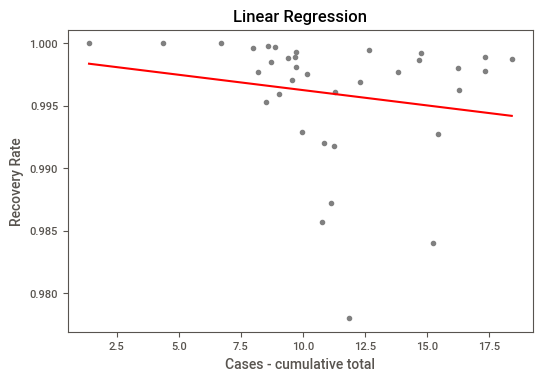

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Transform the two columns into a feature vector
vector_assembler = VectorAssembler(inputCols=['Cases - cumulative total'], outputCol='features')
vwestern_pacific_data = vector_assembler.transform(Western_Pacific_data)

# Perform linear regression
lr = LinearRegression(featuresCol='features', labelCol='Recovery Rate')
lr_model = lr.fit(vwestern_pacific_data)
training_summary = lr_model.summary

print("Coefficient of determination (R^2):", training_summary.r2)
print("Intercept:", lr_model.intercept)
print("Slope:", lr_model.coefficients)

# Plotting
predictions = lr_model.transform(vwestern_pacific_data)
x = predictions.toPandas()['Cases - cumulative total'].values
y = predictions.toPandas()['Recovery Rate'].values
y_pred = predictions.toPandas()['prediction'].values

plt.scatter(x, y, color='gray')
plt.plot(x, y_pred, color='red')
plt.xlabel('Cases - cumulative total')
plt.ylabel('Recovery Rate')
plt.title('Linear Regression')
plt.show()


### 6.3 Build/Select Model with Algorithm/Model Parameter

In [17]:
import findspark

In [18]:
findspark.init()

In [19]:
from pyspark.sql import SparkSession

In [20]:
spark = SparkSession.builder.appName('lr_example').getOrCreate()

In [21]:
from pyspark.ml.regression import LinearRegression

In [22]:
# Print the Schema of the DataFrame
Western_Pacific_data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- WHO Region: string (nullable = true)
 |-- Cases - cumulative total: double (nullable = true)
 |-- Cases - cumulative total per 100000 population: double (nullable = true)
 |-- Cases - newly reported in last 7 days: integer (nullable = true)
 |-- Cases - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Deaths - cumulative total: integer (nullable = true)
 |-- Deaths - cumulative total per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 7 days per 100000 population: double (nullable = true)
 |-- Deaths - newly reported in last 24 hours: integer (nullable = true)
 |-- Death Rate: double (nullable = true)
 |-- Recovery Rate: double (nullable = true)



In [23]:
# The data should to be in the form of two columns
# ("label","features")
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [24]:
Western_Pacific_data.columns

['Name',
 'WHO Region',
 'Cases - cumulative total',
 'Cases - cumulative total per 100000 population',
 'Cases - newly reported in last 7 days',
 'Cases - newly reported in last 7 days per 100000 population',
 'Deaths - cumulative total',
 'Deaths - cumulative total per 100000 population',
 'Deaths - newly reported in last 7 days per 100000 population',
 'Deaths - newly reported in last 24 hours',
 'Death Rate',
 'Recovery Rate']

### 7 Data Mining

In [25]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["Death Rate", "Recovery Rate", "Cases - cumulative total", "Deaths - cumulative total"],
    outputCol="features") 

In [26]:
output = assembler.transform(Western_Pacific_data)

In [27]:
output.select("features").show(3)

+--------------------+
|            features|
+--------------------+
|[0.00122484259285...|
|[0.00220964814014...|
|[0.00105532871711...|
+--------------------+
only showing top 3 rows



In [28]:
output.show(1)

+-----+---------------+------------------------+----------------------------------------------+-------------------------------------+-----------------------------------------------------------+-------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------+--------------------+------------------+--------------------+
| Name|     WHO Region|Cases - cumulative total|Cases - cumulative total per 100000 population|Cases - newly reported in last 7 days|Cases - newly reported in last 7 days per 100000 population|Deaths - cumulative total|Deaths - cumulative total per 100000 population|Deaths - newly reported in last 7 days per 100000 population|Deaths - newly reported in last 24 hours|          Death Rate|     Recovery Rate|            features|
+-----+---------------+------------------------+----------------------------------------------+-------------------------------------+-----

In [29]:
final_data = output.select("features",'Recovery Rate')

In [30]:
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Recovery Rate: double (nullable = true)



In [31]:
final_data.show(3)

+--------------------+------------------+
|            features|     Recovery Rate|
+--------------------+------------------+
|[0.00122484259285...|0.9987751574071472|
|[0.00220964814014...|0.9977903518598567|
|[0.00105532871711...|0.9989446712828817|
+--------------------+------------------+
only showing top 3 rows



We  separated our data set into a training and test set. 

In [42]:
# Pass in the split between training/test as a list.
train_data,test_data = final_data.randomSplit([0.5,0.5])

In [43]:
from pyspark.ml.regression import LinearRegression
# Create a Linear Regression Model object
lr = LinearRegression(labelCol='Recovery Rate')

In [44]:
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data,)

23/10/11 08:07:25 WARN Instrumentation: [28dd65a1] regParam is zero, which might cause numerical instability and overfitting.


Now we only train on the train_data

In [45]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.5307076560661704,1.5307076560660473,-1.7445356025991148e-16,1.5469155247629697e-20] Intercept: -0.5307076560660463


Now we can directly get a .summary object using the evaluate method:

In [46]:
test_results = lrModel.evaluate(test_data)

In [47]:
test_results.residuals.show()
print("RMSE: {}".format(test_results.rootMeanSquaredError))

+--------------------+
|           residuals|
+--------------------+
|1.110223024625156...|
|6.661338147750939...|
|8.881784197001252...|
|1.665334536937734...|
|6.661338147750939...|
|1.332267629550187...|
|2.220446049250313...|
|4.440892098500626...|
|8.881784197001252...|
|6.661338147750939...|
|                 0.0|
|-9.99200722162640...|
|-1.88737914186276...|
+--------------------+

RMSE: 9.717805955881667e-16


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Well that is nice, but realistically we will eventually want to test this model against unlabeled data, after all, that is the whole point of building the model in the first place. We can again do this with a convenient method call, in this case, transform(). Which was actually being called within the evaluate() method. Let's see it in action:

In [48]:
unlabeled_data = test_data.select('features')

<h2 id="prediction">Prediction</h2>

In [49]:
predictions = lrModel.transform(unlabeled_data)

In [50]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[0.0,1.0,6.715383...|0.9999999999999999|
|[1.85425551641016...|0.9998145744483583|
|[7.13478803733872...|0.9992865211962653|
|[7.38479017254846...|0.9992615209827435|
|[0.00105603180519...|0.9989439681948061|
|[0.00136572961852...|0.9986342703814725|
|[0.00145725388601...|0.9985427461139894|
|[0.00184798807749...|0.9981520119225032|
|[0.00306726031029...|0.9969327396897075|
|[0.00371760550273...|0.9962823944972617|
|[0.00707972791633...|0.9929202720836611|
|[0.01429668828951...|0.9857033117104824|
|[0.02199510580106...|0.9780048941989367|
+--------------------+------------------+



In [51]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))

RMSE: 9.717805955881667e-16
MSE: 9.44357525961692e-31


23/10/11 09:10:16 WARN Instrumentation: [a1063e7a] regParam is zero, which might cause numerical instability and overfitting.


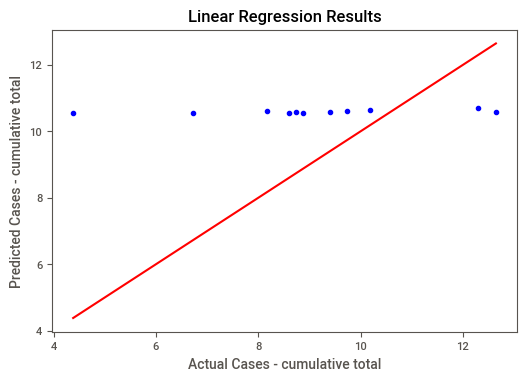

In [57]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Linear Regression with PySpark") \
    .getOrCreate()

# Feature engineering using VectorAssembler
assembler = VectorAssembler(
    inputCols=["Death Rate", "Recovery Rate", "Deaths - cumulative total"],
    outputCol="features")
output = assembler.transform(Western_Pacific_data)

# Selecting necessary columns for regression model
final_data = output.select("features", 'Cases - cumulative total')

# Splitting the data
train_data, test_data = final_data.randomSplit([0.7, 0.3])

# Defining and fitting the model
lr = LinearRegression(labelCol='Cases - cumulative total')
lrModel = lr.fit(train_data)

# Predicting on test data
test_results = lrModel.evaluate(test_data)
predictions = test_results.predictions

# Extracting predicted and actual values for plotting
actual = predictions.select("Cases - cumulative total").rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Plotting the actual vs predicted values
plt.scatter(actual, predicted, color='blue')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # regression line
plt.xlabel('Actual Cases - cumulative total')
plt.ylabel('Predicted Cases - cumulative total')
plt.title('Linear Regression Results')
plt.show()


### 8.5 Adjust the Model

Root Mean Squared Error (RMSE) on test data = 2.75374563328582


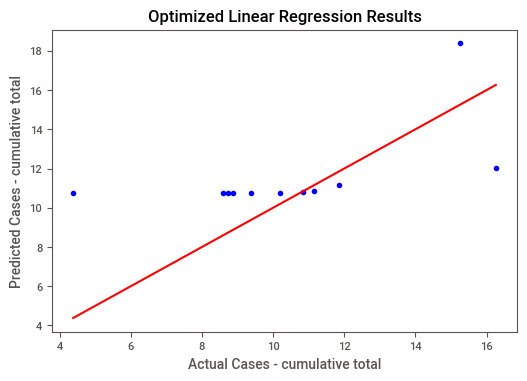

In [55]:
from pyspark.ml.feature import StandardScaler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Feature Engineering

# Feature Scaling: Standardization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)

# Feature Transformation: Polynomial Expansion to capture non-linear relationships
polyExpansion = PolynomialExpansion(degree=2, inputCol="scaledFeatures", outputCol="polyFeatures")
polyData = polyExpansion.transform(scaledData)

# 2. Model Selection and Tuning

# Linear Regression with L1 and L2 regularization (ElasticNet)
lr = LinearRegression(featuresCol="polyFeatures", labelCol='Cases - cumulative total', elasticNetParam=0.8)

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation for model selection
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Cases - cumulative total"),
                          numFolds=3)

# Splitting the data into training and testing sets
train_data, test_data = polyData.randomSplit([0.7, 0.3])

# Train the model
cvModel = crossval.fit(train_data)

# Make predictions on test data
predictions = cvModel.transform(test_data)

# Model Evaluation
evaluator = RegressionEvaluator(labelCol="Cases - cumulative total", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Plotting the actual vs predicted values
actual = predictions.select("Cases - cumulative total").rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.scatter(actual, predicted, color='blue')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # regression line
plt.xlabel('Actual Cases - cumulative total')
plt.ylabel('Predicted Cases - cumulative total')
plt.title('Optimized Linear Regression Results')
plt.show()
